In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import numpy as np

In [3]:
#Separate dates for future plotting
load = pd.read_csv('./dataset_train_4_0to200.csv')



In [4]:
# Removing "," from columns "Load in Houston" , "Ercot Load" and "Settlement Point Price"
load['Load in Houston'] = load['Load in Houston'].astype(str).str.replace(r',', '')
#load['Ercot Load'] = load['Ercot Load'].astype(str).str.replace(r',', '')
load['Settlement Point Price'] = load['Settlement Point Price'].astype(str).str.replace(r',', '')
load.head()

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,DayStatus,Temperature in F,Load in Houston,Settlement Point Price
0,1/1/2015,1,N,LZ_HOUSTON,LZ,Public Holiday,44,9844.2,22.47
1,1/1/2015,2,N,LZ_HOUSTON,LZ,Public Holiday,44,9653.46,22.31
2,1/1/2015,3,N,LZ_HOUSTON,LZ,Public Holiday,44,9502.3,22.2
3,1/1/2015,4,N,LZ_HOUSTON,LZ,Public Holiday,44,9474.48,22.13
4,1/1/2015,5,N,LZ_HOUSTON,LZ,Public Holiday,44,9554.37,22.16


In [5]:
load['Settlement Point Price'] = load['Settlement Point Price'].astype(float)
load['Temperature in F'] = load['Temperature in F'].astype(float)
load['Load in Houston'] = load['Load in Houston'].astype(float)
#load['Ercot Load'] = load['Ercot Load'].astype(float)
load['Settlement Point Price'] = round(load['Settlement Point Price'],2)
load.dtypes
dataset = load.values

In [6]:
load.dtypes

import datetime
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year
load['day'] = pd.DatetimeIndex(load['Delivery Date']).day# Extracting Day from "Delivery Date"
load['month'] = pd.DatetimeIndex(load['Delivery Date']).month   # Extracting Month from "Delivery Date"


a = load['Delivery Date']
a= pd.to_datetime(a)

load['dayofweek'] = a.dt.dayofweek
load['dayofweek'] 

0        3
1        3
2        3
3        3
4        3
        ..
34633    0
34634    0
34635    0
34636    0
34637    0
Name: dayofweek, Length: 34638, dtype: int64

In [7]:
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year

In [8]:
load = load.set_index(['Delivery Date']) 
load = load.drop(columns=['year','day','Settlement Point Name','Settlement Point Type'], axis=1)  
# Re-arranging Columns
load = load[['dayofweek','month','Delivery Hour','Temperature in F','Load in Houston', 'Settlement Point Price']]
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44.0,9844.20,22.47
1/1/2015,3,1,2,44.0,9653.46,22.31
1/1/2015,3,1,3,44.0,9502.30,22.20
1/1/2015,3,1,4,44.0,9474.48,22.13
1/1/2015,3,1,5,44.0,9554.37,22.16


In [9]:

#Variables for training
cols = list(load)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['month', 'Delivery Hour', 'Temperature in F', 'Load in Houston', 'Settlement Point Price']


In [10]:
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44.0,9844.20,22.47
1/1/2015,3,1,2,44.0,9653.46,22.31
1/1/2015,3,1,3,44.0,9502.30,22.20
1/1/2015,3,1,4,44.0,9474.48,22.13
1/1/2015,3,1,5,44.0,9554.37,22.16


In [11]:
load3 = load

In [12]:
load3.index=pd.to_datetime(load3.index)

In [13]:
train_XG=load3.loc[load3.index < '1/1/2018']

In [14]:
test_XG=load3.loc[load3.index >= '1/1/2018']

In [15]:
len(test_XG)

8651

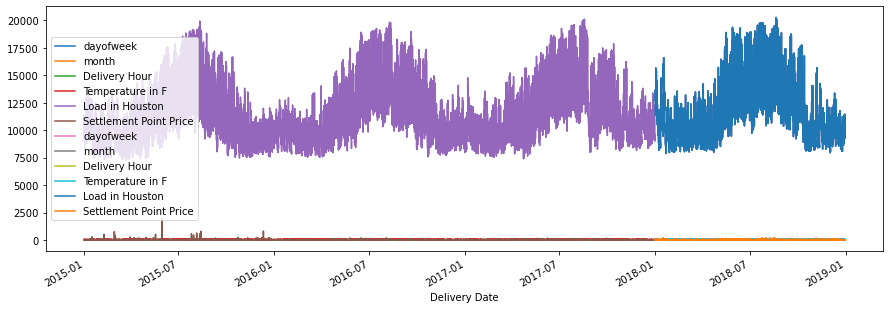

In [16]:
fig , ax = plt.subplots(figsize=(15,5))
load.plot(ax=ax, label='Training Set')
test_XG.plot(ax=ax, label='Test Set')
plt.show()

<AxesSubplot:xlabel='Delivery Date'>

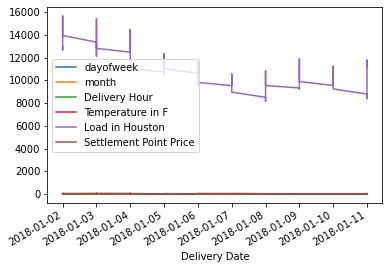

In [17]:
load3.loc[(load3.index > '1/1/2018') & (load3.index < '1/12/2018')].plot()

In [18]:
Features=['dayofweek','month','Delivery Hour' ,'Temperature in F','Load in Houston']
TARGET='Settlement Point Price'

In [19]:
X_train_xgb=train_XG[Features]
Y_train_xgb=train_XG[TARGET]
X_test_xgb= test_XG[Features]
Y_test_xgb= test_XG[TARGET]

In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.001)

In [22]:
reg.fit(X_train_xgb,Y_train_xgb,eval_set=[(X_train_xgb,Y_train_xgb),(X_test_xgb,Y_test_xgb)],verbose=True)

[0]	validation_0-rmse:34.01056	validation_1-rmse:29.10304
[1]	validation_0-rmse:33.99089	validation_1-rmse:29.08051
[2]	validation_0-rmse:33.97125	validation_1-rmse:29.05784
[3]	validation_0-rmse:33.95163	validation_1-rmse:29.03536
[4]	validation_0-rmse:33.93204	validation_1-rmse:29.01274
[5]	validation_0-rmse:33.91248	validation_1-rmse:28.99031
[6]	validation_0-rmse:33.89295	validation_1-rmse:28.96774
[7]	validation_0-rmse:33.87344	validation_1-rmse:28.94537
[8]	validation_0-rmse:33.85395	validation_1-rmse:28.92285
[9]	validation_0-rmse:33.83450	validation_1-rmse:28.90053
[10]	validation_0-rmse:33.81507	validation_1-rmse:28.87807
[11]	validation_0-rmse:33.79566	validation_1-rmse:28.85580
[12]	validation_0-rmse:33.77629	validation_1-rmse:28.83339
[13]	validation_0-rmse:33.75694	validation_1-rmse:28.81117
[14]	validation_0-rmse:33.73761	validation_1-rmse:28.78881
[15]	validation_0-rmse:33.71831	validation_1-rmse:28.76664
[16]	validation_0-rmse:33.69904	validation_1-rmse:28.74434
[17]	va

[139]	validation_0-rmse:31.39533	validation_1-rmse:26.22018
[140]	validation_0-rmse:31.37570	validation_1-rmse:26.20110
[141]	validation_0-rmse:31.35608	validation_1-rmse:26.18203
[142]	validation_0-rmse:31.34023	validation_1-rmse:26.16333
[143]	validation_0-rmse:31.32065	validation_1-rmse:26.14431
[144]	validation_0-rmse:31.30101	validation_1-rmse:26.12533
[145]	validation_0-rmse:31.28466	validation_1-rmse:26.10611
[146]	validation_0-rmse:31.26507	validation_1-rmse:26.08717
[147]	validation_0-rmse:31.24551	validation_1-rmse:26.06826
[148]	validation_0-rmse:31.22976	validation_1-rmse:26.04969
[149]	validation_0-rmse:31.21025	validation_1-rmse:26.03082
[150]	validation_0-rmse:31.19074	validation_1-rmse:26.01198
[151]	validation_0-rmse:31.17454	validation_1-rmse:25.99305
[152]	validation_0-rmse:31.15508	validation_1-rmse:25.97424
[153]	validation_0-rmse:31.13572	validation_1-rmse:25.95546
[154]	validation_0-rmse:31.12008	validation_1-rmse:25.93702
[155]	validation_0-rmse:31.10068	validat

[275]	validation_0-rmse:29.09286	validation_1-rmse:23.81436
[276]	validation_0-rmse:29.07768	validation_1-rmse:23.79842
[277]	validation_0-rmse:29.06068	validation_1-rmse:23.78157
[278]	validation_0-rmse:29.04479	validation_1-rmse:23.76540
[279]	validation_0-rmse:29.02783	validation_1-rmse:23.74862
[280]	validation_0-rmse:29.01196	validation_1-rmse:23.73248
[281]	validation_0-rmse:28.99688	validation_1-rmse:23.71663
[282]	validation_0-rmse:28.98317	validation_1-rmse:23.70040
[283]	validation_0-rmse:28.96812	validation_1-rmse:23.68459
[284]	validation_0-rmse:28.95122	validation_1-rmse:23.66788
[285]	validation_0-rmse:28.93547	validation_1-rmse:23.65186
[286]	validation_0-rmse:28.92049	validation_1-rmse:23.63609
[287]	validation_0-rmse:28.90477	validation_1-rmse:23.62011
[288]	validation_0-rmse:28.88798	validation_1-rmse:23.60357
[289]	validation_0-rmse:28.87230	validation_1-rmse:23.58762
[290]	validation_0-rmse:28.85739	validation_1-rmse:23.57192
[291]	validation_0-rmse:28.84175	validat

[411]	validation_0-rmse:27.08891	validation_1-rmse:21.76419
[412]	validation_0-rmse:27.07413	validation_1-rmse:21.74983
[413]	validation_0-rmse:27.06042	validation_1-rmse:21.73576
[414]	validation_0-rmse:27.04730	validation_1-rmse:21.72223
[415]	validation_0-rmse:27.03232	validation_1-rmse:21.70787
[416]	validation_0-rmse:27.01851	validation_1-rmse:21.69390
[417]	validation_0-rmse:27.00543	validation_1-rmse:21.68042
[418]	validation_0-rmse:26.99051	validation_1-rmse:21.66606
[419]	validation_0-rmse:26.97882	validation_1-rmse:21.65233
[420]	validation_0-rmse:26.96580	validation_1-rmse:21.63892
[421]	validation_0-rmse:26.95092	validation_1-rmse:21.62460
[422]	validation_0-rmse:26.93794	validation_1-rmse:21.61122
[423]	validation_0-rmse:26.92424	validation_1-rmse:21.59736
[424]	validation_0-rmse:26.91128	validation_1-rmse:21.58400
[425]	validation_0-rmse:26.89658	validation_1-rmse:21.56977
[426]	validation_0-rmse:26.88203	validation_1-rmse:21.55570
[427]	validation_0-rmse:26.86839	validat

[548]	validation_0-rmse:25.32191	validation_1-rmse:20.00114
[549]	validation_0-rmse:25.31051	validation_1-rmse:19.98936
[550]	validation_0-rmse:25.29885	validation_1-rmse:19.97754
[551]	validation_0-rmse:25.28581	validation_1-rmse:19.96561
[552]	validation_0-rmse:25.27446	validation_1-rmse:19.95385
[553]	validation_0-rmse:25.26269	validation_1-rmse:19.94207
[554]	validation_0-rmse:25.24978	validation_1-rmse:19.93013
[555]	validation_0-rmse:25.23679	validation_1-rmse:19.91827
[556]	validation_0-rmse:25.22522	validation_1-rmse:19.90658
[557]	validation_0-rmse:25.21394	validation_1-rmse:19.89490
[558]	validation_0-rmse:25.20100	validation_1-rmse:19.88299
[559]	validation_0-rmse:25.18947	validation_1-rmse:19.87128
[560]	validation_0-rmse:25.17657	validation_1-rmse:19.85937
[561]	validation_0-rmse:25.16367	validation_1-rmse:19.84755
[562]	validation_0-rmse:25.15218	validation_1-rmse:19.83595
[563]	validation_0-rmse:25.14097	validation_1-rmse:19.82478
[564]	validation_0-rmse:25.12812	validat

[685]	validation_0-rmse:23.75879	validation_1-rmse:18.50705
[686]	validation_0-rmse:23.74891	validation_1-rmse:18.49710
[687]	validation_0-rmse:23.73815	validation_1-rmse:18.48692
[688]	validation_0-rmse:23.72829	validation_1-rmse:18.47694
[689]	validation_0-rmse:23.71683	validation_1-rmse:18.46711
[690]	validation_0-rmse:23.70539	validation_1-rmse:18.45730
[691]	validation_0-rmse:23.69557	validation_1-rmse:18.44741
[692]	validation_0-rmse:23.68486	validation_1-rmse:18.43731
[693]	validation_0-rmse:23.67416	validation_1-rmse:18.42723
[694]	validation_0-rmse:23.66277	validation_1-rmse:18.41748
[695]	validation_0-rmse:23.65300	validation_1-rmse:18.40761
[696]	validation_0-rmse:23.64374	validation_1-rmse:18.39798
[697]	validation_0-rmse:23.63400	validation_1-rmse:18.38812
[698]	validation_0-rmse:23.62336	validation_1-rmse:18.37810
[699]	validation_0-rmse:23.61205	validation_1-rmse:18.36844
[700]	validation_0-rmse:23.60234	validation_1-rmse:18.35867
[701]	validation_0-rmse:23.59175	validat

[822]	validation_0-rmse:22.43520	validation_1-rmse:17.25951
[823]	validation_0-rmse:22.42575	validation_1-rmse:17.25153
[824]	validation_0-rmse:22.41743	validation_1-rmse:17.24311
[825]	validation_0-rmse:22.40825	validation_1-rmse:17.23480
[826]	validation_0-rmse:22.39997	validation_1-rmse:17.22656
[827]	validation_0-rmse:22.39040	validation_1-rmse:17.21865
[828]	validation_0-rmse:22.38212	validation_1-rmse:17.21044
[829]	validation_0-rmse:22.37300	validation_1-rmse:17.20231
[830]	validation_0-rmse:22.36387	validation_1-rmse:17.19405
[831]	validation_0-rmse:22.35475	validation_1-rmse:17.18584
[832]	validation_0-rmse:22.34653	validation_1-rmse:17.17767
[833]	validation_0-rmse:22.33831	validation_1-rmse:17.16939
[834]	validation_0-rmse:22.32887	validation_1-rmse:17.16153
[835]	validation_0-rmse:22.32070	validation_1-rmse:17.15338
[836]	validation_0-rmse:22.31165	validation_1-rmse:17.14533
[837]	validation_0-rmse:22.30228	validation_1-rmse:17.13737
[838]	validation_0-rmse:22.29411	validat

[959]	validation_0-rmse:21.30668	validation_1-rmse:16.23192
[960]	validation_0-rmse:21.30032	validation_1-rmse:16.22505
[961]	validation_0-rmse:21.29184	validation_1-rmse:16.21845
[962]	validation_0-rmse:21.28483	validation_1-rmse:16.21165
[963]	validation_0-rmse:21.27695	validation_1-rmse:16.20484
[964]	validation_0-rmse:21.26908	validation_1-rmse:16.19807
[965]	validation_0-rmse:21.26087	validation_1-rmse:16.19156
[966]	validation_0-rmse:21.25389	validation_1-rmse:16.18481
[967]	validation_0-rmse:21.24605	validation_1-rmse:16.17804
[968]	validation_0-rmse:21.23975	validation_1-rmse:16.17126
[969]	validation_0-rmse:21.23149	validation_1-rmse:16.16473
[970]	validation_0-rmse:21.22455	validation_1-rmse:16.15802
[971]	validation_0-rmse:21.21827	validation_1-rmse:16.15126
[972]	validation_0-rmse:21.21059	validation_1-rmse:16.14463
[973]	validation_0-rmse:21.20280	validation_1-rmse:16.13794
[974]	validation_0-rmse:21.19589	validation_1-rmse:16.13127
[975]	validation_0-rmse:21.18813	validat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
test_XG['prediction']=reg.predict(X_test_xgb)

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_41920\1787262806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_XG['prediction']=reg.predict(X_test_xgb)


In [24]:
error_p = np.round(test_XG['prediction'],2) - np.round(test_XG['Settlement Point Price'],2)
i=0
count=0
for i in range(len(error_p)):
    if ((error_p[i])>5) or ((error_p[i]<-5)):
        count=count+1
a = len(test_XG['prediction']) - count
accuracy = (a/len(test_XG['prediction']))*100
print('accuracy:', accuracy)    

for j in range(1,11):
    i=0
    count=0
    for i in range(len(error_p)):
        if ((error_p[i])>j) or ((error_p[i]<-j)):
            count=count+1
    a = len(test_XG['prediction']) - count
    accuracy = (a/len(test_XG['prediction']))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: 21.847185296497514
accuracy: with threshold of 1  is 2.09
accuracy: with threshold of 2  is 4.75
accuracy: with threshold of 3  is 8.47
accuracy: with threshold of 4  is 14.26
accuracy: with threshold of 5  is 21.85
accuracy: with threshold of 6  is 33.18
accuracy: with threshold of 7  is 44.54
accuracy: with threshold of 8  is 54.62
accuracy: with threshold of 9  is 62.03
accuracy: with threshold of 10  is 67.70


In [25]:
load3=load3.merge(test_XG[['prediction']],how='left', left_index=True, right_index=True)

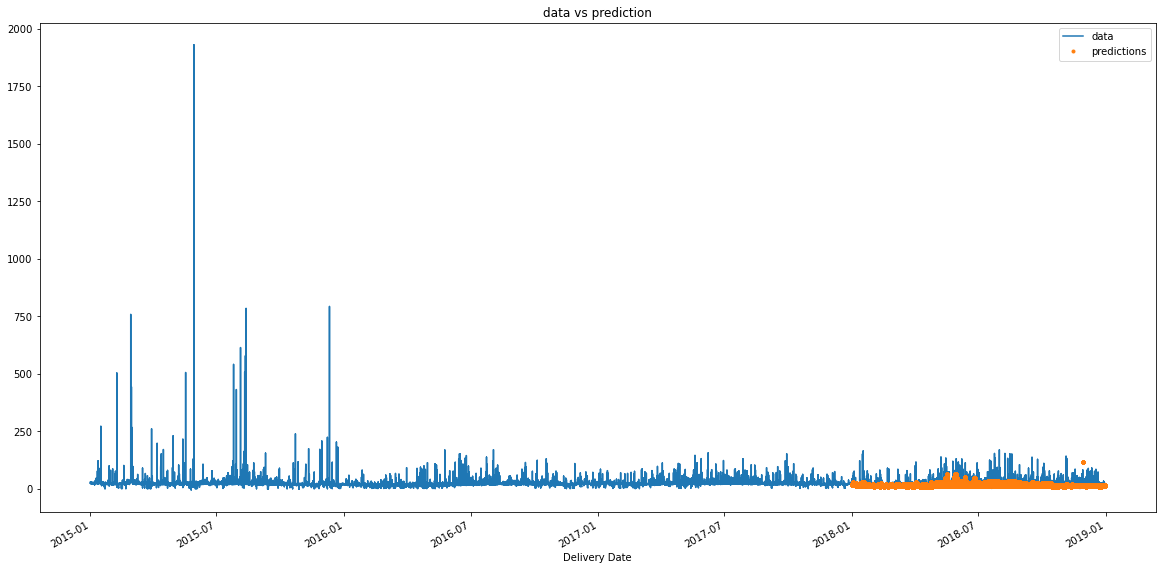

In [26]:
ax=load[['Settlement Point Price']].plot(figsize=(20,10))
load3['prediction'].plot(ax=ax,style='.')
plt.legend(['data','predictions'])
ax.set_title('data vs prediction')
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test_XG['Settlement Point Price'],test_XG['prediction']))

In [28]:
print(score)

15.969831079709293


In [29]:
r2_score(test_XG['Settlement Point Price'],test_XG['prediction'])

-0.262003761101812

In [30]:
mean_squared_error(test_XG['Settlement Point Price'],test_XG['prediction'])

255.03550471444885

In [31]:
test_XG['error']=np.abs(test_XG[TARGET]-test_XG['prediction'])

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_41920\294912609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_XG['error']=np.abs(test_XG[TARGET]-test_XG['prediction'])


In [32]:
test_XG['date']=test_XG.index.date
test_XG.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_41920\1325165062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_XG['date']=test_XG.index.date


date
2018-01-17    43.547835
2018-11-06    37.899277
2018-11-05    32.605754
2018-01-18    30.988060
2018-01-03    30.089497
Name: error, dtype: float64

In [33]:
test_XG.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2018-02-19    2.668744
2018-01-07    2.846915
2018-03-15    2.999340
2018-01-15    3.188953
2018-01-14    3.319373
Name: error, dtype: float64